# Introduction

(i) Train segmentation models for the patches extracted from the aerial MapAI data. Pretrained on the Inria dataset.

# Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from datetime import date

In [3]:
from fastai.vision.all import *
from fastai_metrics import * 
from loss_functions import CombinedCEFocalTverskyLoss 

In [4]:
torch.cuda.set_device(0)

In [5]:
from constants import DATADIR, MAPAI_MASKS, MAPAI_TRAIN, MAPAI_PATCHES

# Load MapAI image patches

In [6]:
df = pd.read_csv(f'../csv/mapai_orig_and_fixed_patches_2022-11-26.csv')

In [7]:
df.head()

,image,lidar,mask,is_val,mask_percentage,is_building,location
0,/home/ubuntu/data/mapai/data/train/images/6179_495_44.tif,/home/ubuntu/data/mapai/data/train/lidar/6179_495_44.tif,/home/ubuntu/data/mapai/data/train/masks/6179_495_44.tif,False,0.155224,True,6179_495
1,/home/ubuntu/data/mapai/data/train/images/6051_690_84.tif,/home/ubuntu/data/mapai/data/train/lidar/6051_690_84.tif,/home/ubuntu/data/mapai/data/train/masks/6051_690_84.tif,False,0.000000,False,6051_690
2,/home/ubuntu/data/mapai/data/train/images/6121_865_53.tif,/home/ubuntu/data/mapai/data/train/lidar/6121_865_53.tif,/home/ubuntu/data/mapai/data/train/masks/6121_865_53.tif,False,0.017824,True,6121_865
3,/home/ubuntu/data/mapai/data/train/images/6173_630_27.tif,/home/ubuntu/data/mapai/data/train/lidar/6173_630_27.tif,/home/ubuntu/data/mapai/data/train/masks/6173_630_27.tif,False,0.000000,False,6173_630
4,/home/ubuntu/data/mapai/data/train/images/6147_481_4.tif,/home/ubuntu/data/mapai/data/train/lidar/6147_481_4.tif,/home/ubuntu/data/mapai/data/train/masks/6147_481_4.tif,False,0.182664,True,6147_481


In [8]:
len(df)

43500

## Add additional patches stored on Titan

In [9]:
MAPAI_PATCHES

Path('/home/alex/data/mapai/data/train/patches')

In [10]:
ADDITIONAL_PATCHES = Path('/home/alex/data/mapai/data/train/patches_backup')

In [11]:
add_img_patches = sorted(list((ADDITIONAL_PATCHES/'images').glob('*.tif')))
add_mask_patches = sorted(list((ADDITIONAL_PATCHES/'masks').glob('*.tif')))

In [12]:
assert len(add_img_patches) == len(add_mask_patches)
len(add_img_patches)

35000

In [13]:
add_patch_df = pd.DataFrame(data=zip(add_img_patches, add_mask_patches), columns=['image', 'mask'])

In [14]:
add_patch_df['is_val'] = False

In [15]:
add_patch_df.head()

,image,mask,is_val
0,/home/alex/data/mapai/data/train/patches_backup/images/6051_689-0.tif,/home/alex/data/mapai/data/train/patches_backup/masks/6051_689-0.tif,False
1,/home/alex/data/mapai/data/train/patches_backup/images/6051_689-1.tif,/home/alex/data/mapai/data/train/patches_backup/masks/6051_689-1.tif,False
2,/home/alex/data/mapai/data/train/patches_backup/images/6051_689-10.tif,/home/alex/data/mapai/data/train/patches_backup/masks/6051_689-10.tif,False
3,/home/alex/data/mapai/data/train/patches_backup/images/6051_689-100.tif,/home/alex/data/mapai/data/train/patches_backup/masks/6051_689-100.tif,False
4,/home/alex/data/mapai/data/train/patches_backup/images/6051_689-101.tif,/home/alex/data/mapai/data/train/patches_backup/masks/6051_689-101.tif,False


In [16]:
all_df = pd.concat([df[['image', 'mask', 'is_val']], add_patch_df])

In [17]:
all_df.head()

,image,mask,is_val
0,/home/ubuntu/data/mapai/data/train/images/6179_495_44.tif,/home/ubuntu/data/mapai/data/train/masks/6179_495_44.tif,False
1,/home/ubuntu/data/mapai/data/train/images/6051_690_84.tif,/home/ubuntu/data/mapai/data/train/masks/6051_690_84.tif,False
2,/home/ubuntu/data/mapai/data/train/images/6121_865_53.tif,/home/ubuntu/data/mapai/data/train/masks/6121_865_53.tif,False
3,/home/ubuntu/data/mapai/data/train/images/6173_630_27.tif,/home/ubuntu/data/mapai/data/train/masks/6173_630_27.tif,False
4,/home/ubuntu/data/mapai/data/train/images/6147_481_4.tif,/home/ubuntu/data/mapai/data/train/masks/6147_481_4.tif,False


In [18]:
len(all_df)

78500

In [19]:
df = all_df.copy()

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78500 entries, 0 to 34999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   78500 non-null  object
 1   mask    78500 non-null  object
 2   is_val  78500 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 1.9+ MB


In [21]:
df.is_val.value_counts()

False    77000
True      1500
Name: is_val, dtype: int64

# Check data

In [24]:
from plotting import plot_image_and_masks_from_df

<AxesSubplot: title={'center': '6179_495_44, (500, 500)'}>

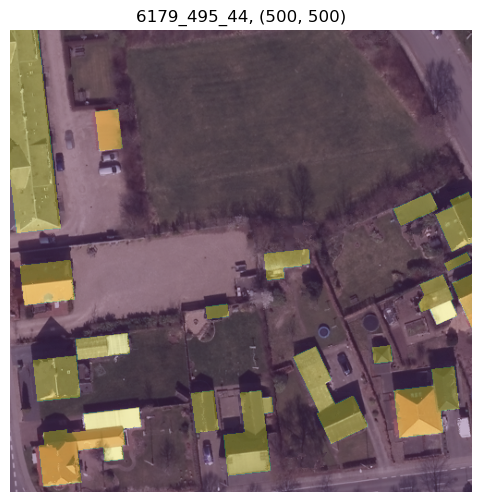

In [25]:
plot_image_and_masks_from_df(0, df)

# Setup data augmentation and create dataloaders

In [25]:
models = [resnet34, resnet50, xresnet34, xresnet50, xresnet50_deep, xresnext50]
model_idx = 0 # Todo: resnet50, xresnet50, xresnext50

In [26]:
model_name = str(models[model_idx]).split(' ')[1]
model_name

'resnet34'

In [27]:
if '34' in model_name:
    rn=34
    bs=32
else:
    rn=50
    bs=16

In [28]:
bs

32

In [29]:
bs=40

In [30]:
from training import get_batch_tfms, get_dataloaders, get_cbs

In [31]:
from training import BinaryConverter

In [32]:
codes = [0,1]

In [33]:
sz = (500,500)

In [34]:
# item_tfms=[Resize(sz), BinaryConverter()] 
#item_tfms=[BinaryConverter()] # Resize on GPU using randomcrops
item_tfms=None

In [35]:
batch_tfms = get_batch_tfms(normalize=Normalize.from_stats(*imagenet_stats), size=None)

In [36]:
dls = get_dataloaders(df, x_name='image', y_name='mask', codes=codes, 
                      splitter=ColSplitter('is_val'), 
                      bs=bs, item_tfms=item_tfms, 
                      batch_tfms=batch_tfms)

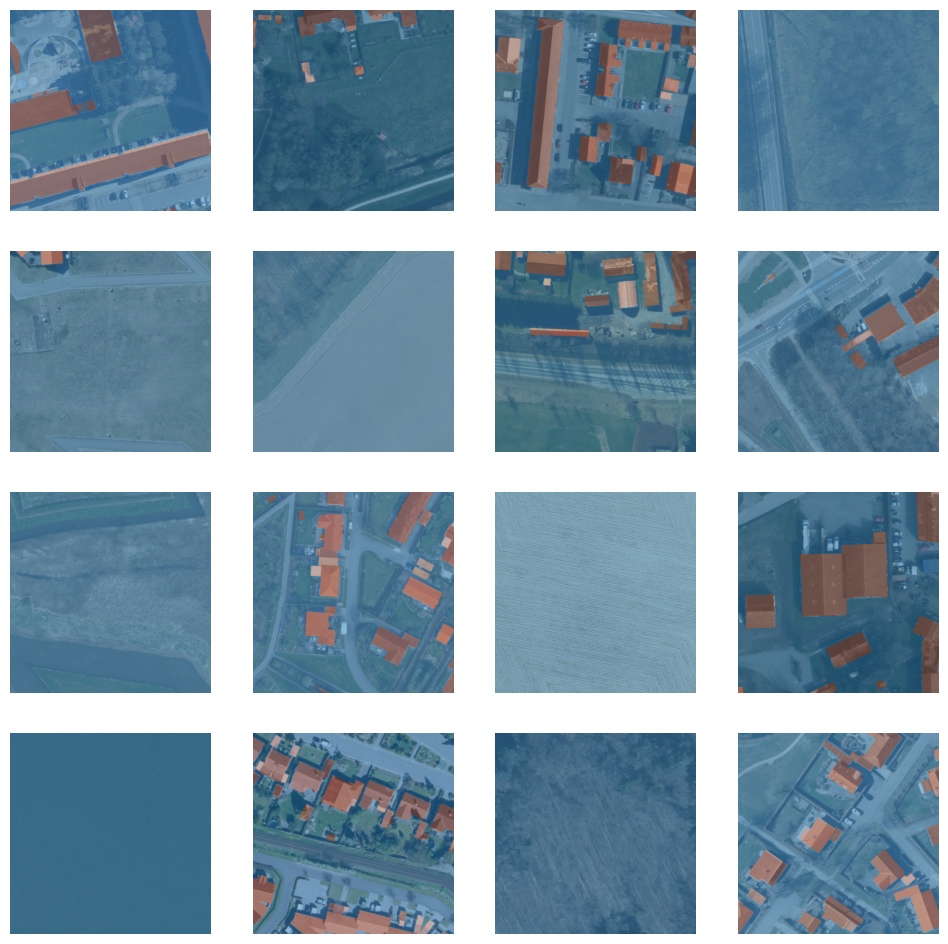

In [36]:
dls.show_batch(max_n=16)

# Create model

In [37]:
from loss_functions import CombinedFocalTanimotoLoss, CombinedCETverskyLoss
from loss_functions import CombinedCEFocalTverskyLoss

In [38]:
#loss_func = FocalTverskyCrossEntropyLoss()
#loss_func = CombinedFocalTanimotoLoss()
loss_func = CombinedCEFocalTverskyLoss()

In [39]:
#opt = ranger

In [40]:
metrics = [Dice, iou]

In [41]:
learn = unet_learner(dls, models[model_idx], metrics=metrics, loss_func=loss_func,  
                     self_attention=True).to_fp16() 

/home/alex/anaconda3/envs/mapai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alex/anaconda3/envs/mapai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Load pretrained weights

In [42]:
save_fn = f'stage-4_resnet34_pretraining-resnet34-2022-11-22-final'
#save_fn = f'stage-4_resnet34_pretraining-2022-12-01-focaltanimoto-final'

In [44]:
# Load pre-trained weights from Inria
learn.load(save_fn);

# Fine-tune model

In [45]:
learn.dls = dls

In [46]:
from training import fine_tune

In [47]:
save_fn = f'MapAI-500_{model_name}-{date.today()}-FocalTanimoto-pretrain2211-model'

In [48]:
save_fn

'MapAI-500_resnet34-2022-12-02-FocalTversky-cutmix-pretrain2211-model'

In [49]:
cbs = get_cbs(fname=save_fn, hole_size=(200,200))

SuggestedLRs(valley=1.737800812406931e-05)

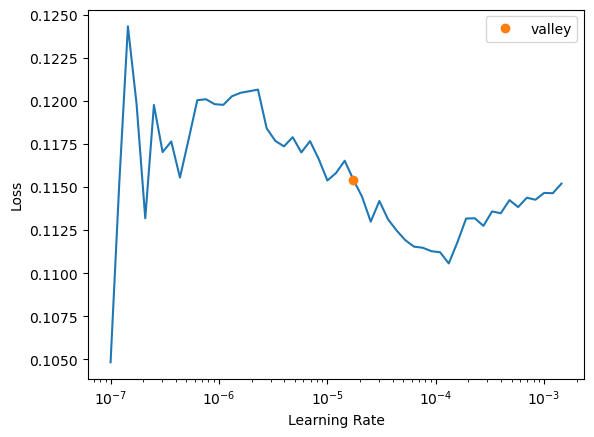

In [49]:
learn.lr_find()

In [33]:
fine_tune(learn, epochs=6, cbs=cbs, freeze_epochs=1, base_lr=1e-3)

Training for 1 epochs with frozen layers


epoch,train_loss,valid_loss,dice,iou,time
0,0.445364,0.482333,0.932066,0.925240,25:34


Better model found at epoch 0 with valid_loss value: 0.4823325276374817.
Training unfrozen model for 5 epochs


epoch,train_loss,valid_loss,dice,iou,time
0,0.429816,0.476800,0.934970,0.928259,26:10
1,0.422536,0.473769,0.936305,0.929717,26:08
2,0.415430,0.470047,0.938287,0.931720,26:08
3,0.406469,0.469885,0.938490,0.931886,26:09
4,0.404756,0.468198,0.939105,0.932531,26:10


Better model found at epoch 0 with valid_loss value: 0.47680044174194336.
Better model found at epoch 1 with valid_loss value: 0.47376880049705505.
Better model found at epoch 2 with valid_loss value: 0.47004687786102295.
Better model found at epoch 4 with valid_loss value: 0.4681975245475769.


## Export

In [51]:
learn_export = unet_learner(dls, models[model_idx], metrics=metrics,  
                     self_attention=True).to_fp16() 

In [52]:
save_fn

'MapAI-500_resnet34-2022-12-02-FocalTversky-cutmix-pretrain2211-model'

In [53]:
learn_export.load(save_fn)

In [54]:
learn_export.export(save_fn + '.pkl')

In [34]:
learn.load(save_fn);

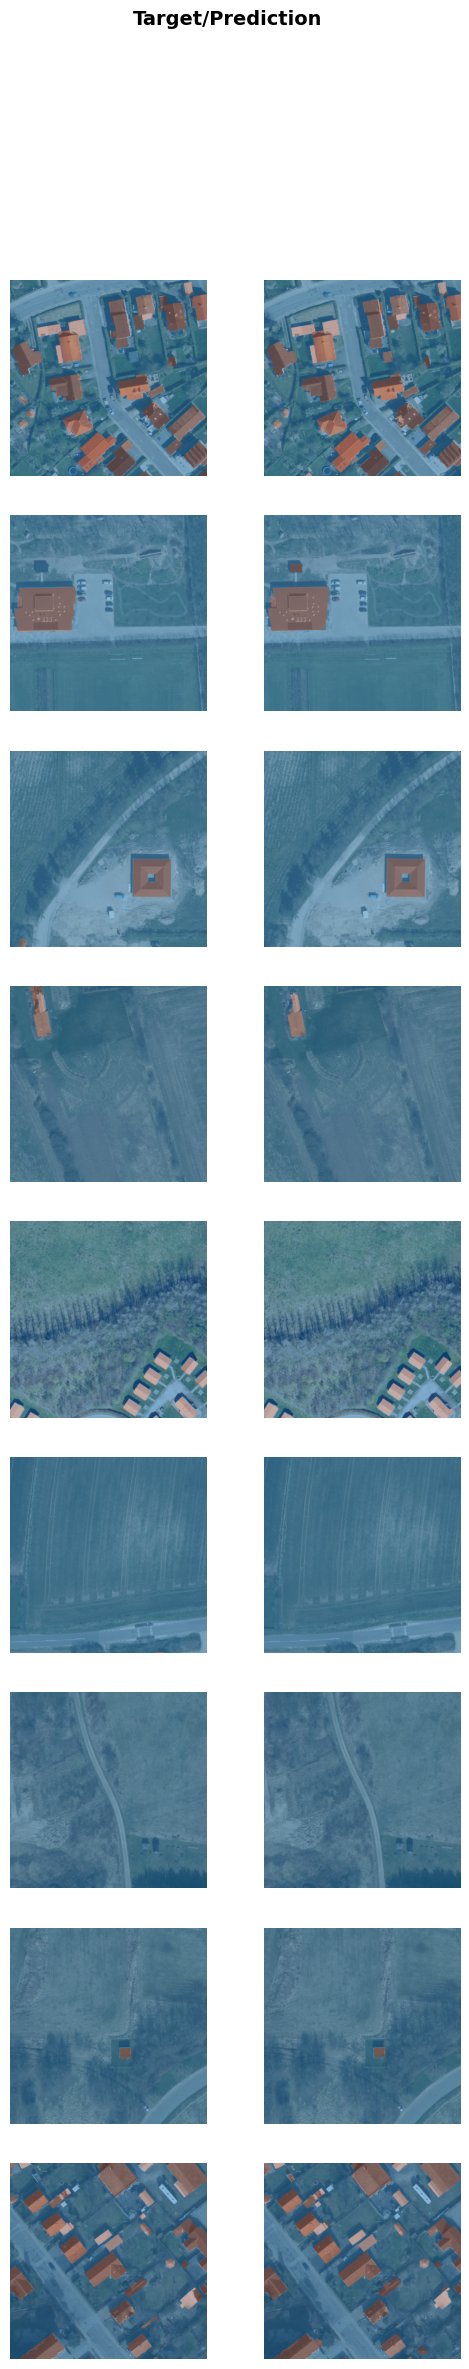

In [35]:
learn.show_results()

# Export

In [36]:
learn.export(f'learn_{model_name}_{date.today()}.pkl')